In [36]:
!pip install numpy
!pip install pandas
!pip install missingno
!pip install -U scikit-learn
!pip install matplotlib
!pip install scipy

In [37]:
import numpy as np
import pandas as pd
import time
import missingno as mno
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression

In [38]:
filepath = "C:\\Users\\TienVNguyen\\Downloads\\archive\\diabetes.csv"

In [39]:
dataset = pd.read_csv(filepath)
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [40]:
# Data set infomation
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Convert Zeros Into NaN.

Although the dataset does not contain null data, these features ('Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age') does not allowed zero values. First we change zeros values in these features into nan.

In [41]:
# Mark zero values as missing or NaN
dataset.loc[:,['Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] = dataset.loc[:,['Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].replace(0, np.nan, regex=True)
# Data set infomation
print(dataset.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


<AxesSubplot: >

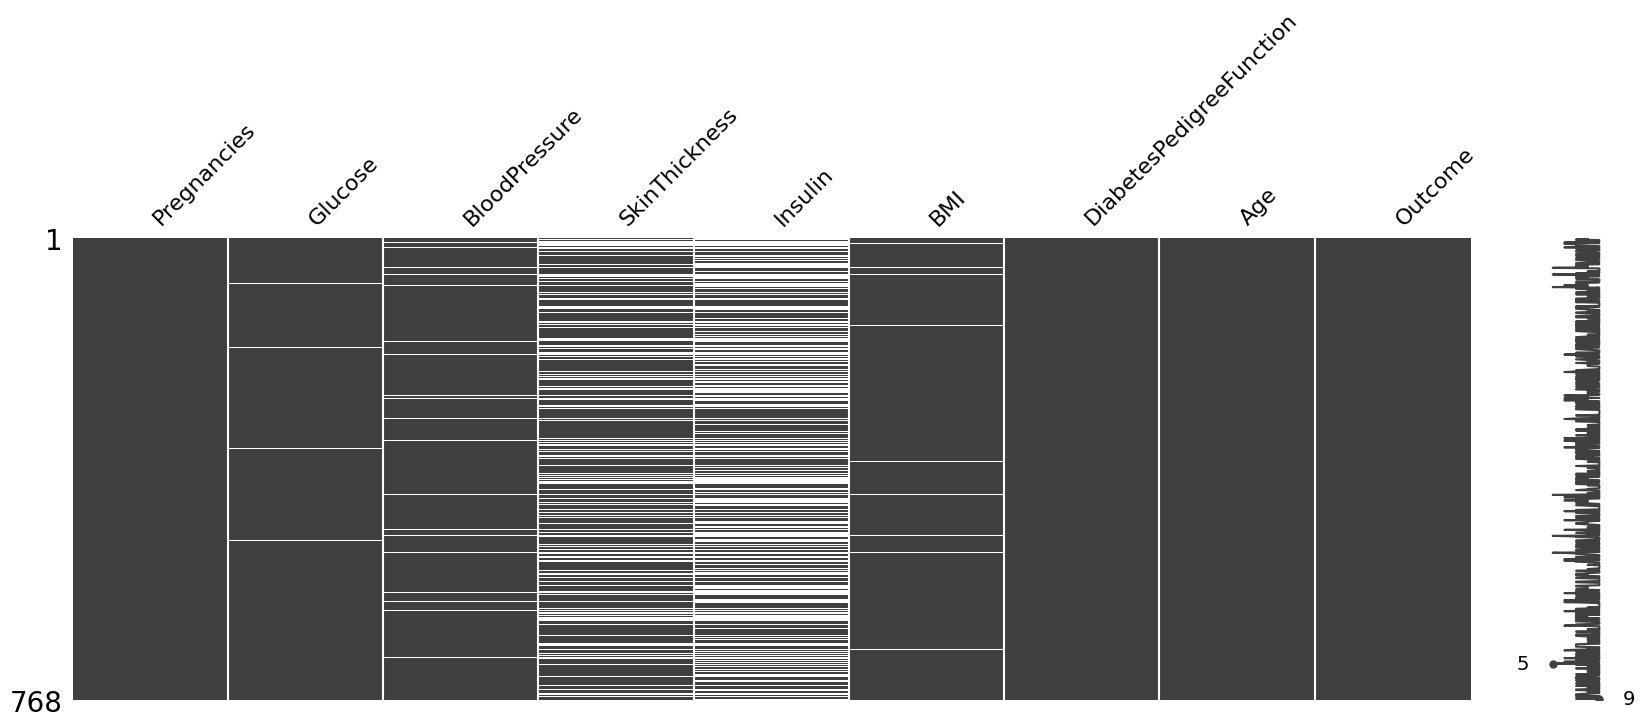

In [42]:
# Visualisation
mno.matrix(dataset, figsize = (20, 6))

In [43]:
# Define missing columns
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

## Mean Imputation

In [44]:
# Mean Imputation
mean_imp_dataset = dataset.fillna(dataset.mean())

<AxesSubplot: >

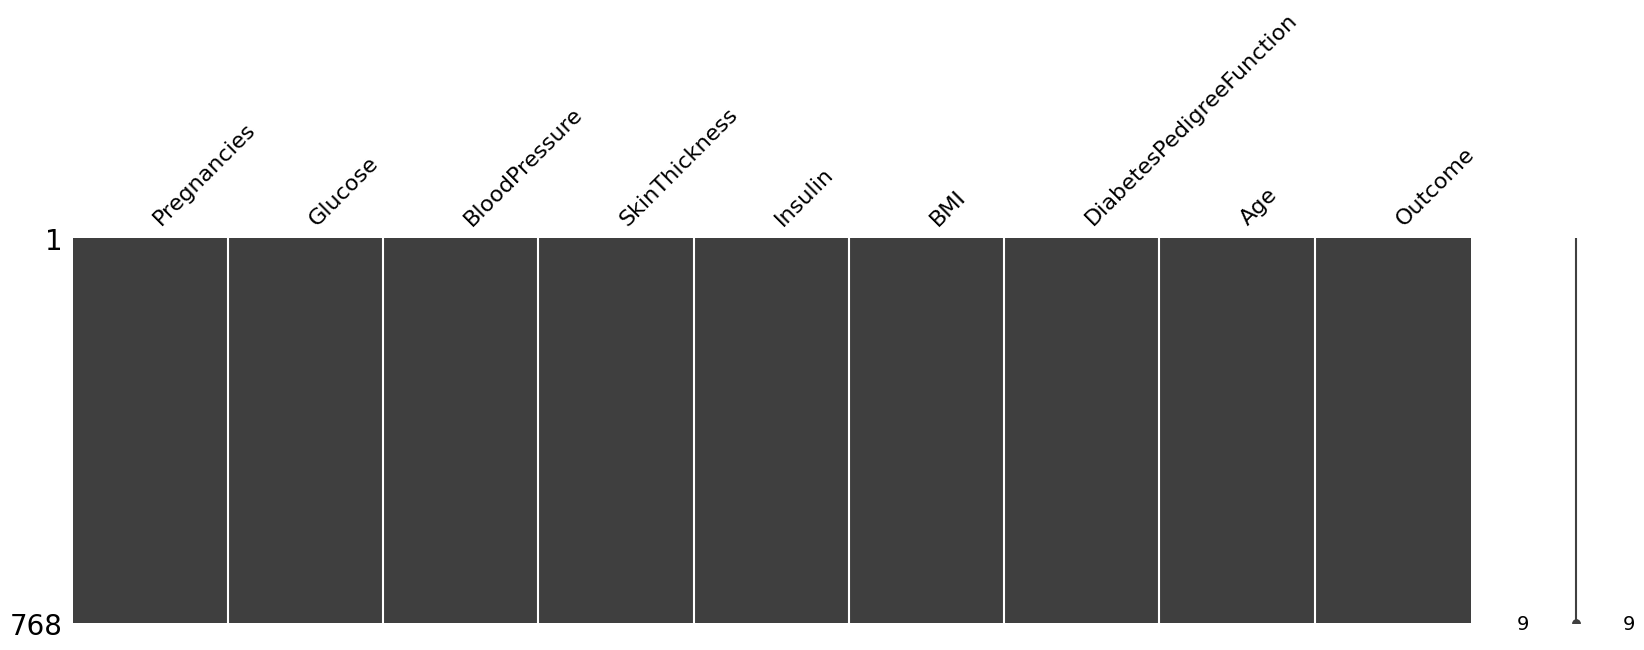

In [45]:
# Mean Imputation Results
mno.matrix(mean_imp_dataset, figsize = (20,5))

## Deterministic Regression Imputation

Here I am using "Mean Imputation results" to train and estimate missing values

In [46]:
# Deterministic Regression Imputation
reg_imp_data = pd.DataFrame(columns = ["reg" + name for name in missing_columns])

for feature in missing_columns:
    reg_imp_data["reg" + feature] = mean_imp_dataset[feature]
    parameters = list(set(dataset.columns) - set(missing_columns))
    # Create a Linear Regression model to estimate the missing data
    model = LinearRegression()
    model.fit(X = dataset[parameters], y = mean_imp_dataset[feature])
    
    reg_imp_data.loc[dataset[feature].isnull(), "reg" + feature] = model.predict(dataset[parameters])[dataset[feature].isnull()]

<AxesSubplot: >

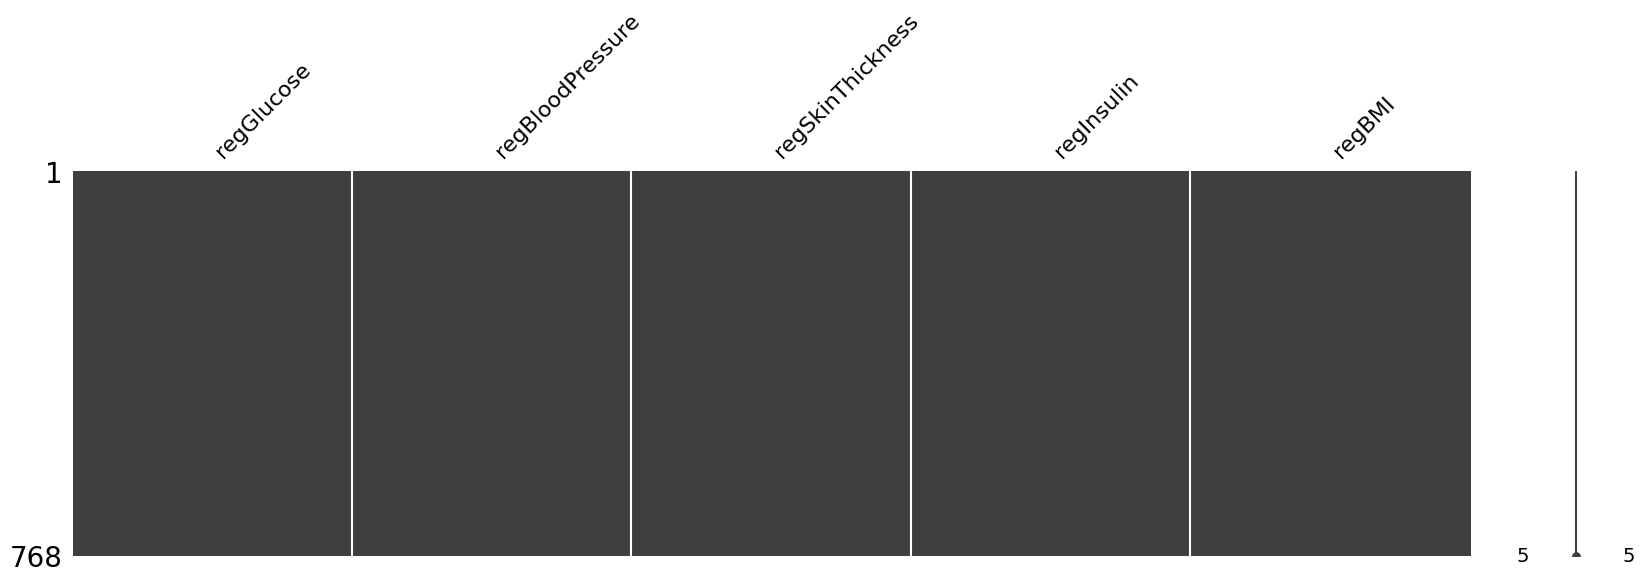

In [47]:
# Deterministic Regression Imputation Results
mno.matrix(reg_imp_data, figsize = (20,5))

## Calculate P-value

In [49]:
# Calculate P-value
statistic = {"Glucose":None, "BloodPressure":None, "SkinThickness":None, "Insulin":None, "BMI":None}
p_value = {"Glucose":None, "BloodPressure":None, "SkinThickness":None, "Insulin":None, "BMI":None}

for feature in missing_columns:
    statistic[feature], p_value[feature] = stats.ttest_1samp(reg_imp_data.loc[dataset[feature].isnull(), "reg" + feature], dataset[feature].mean())

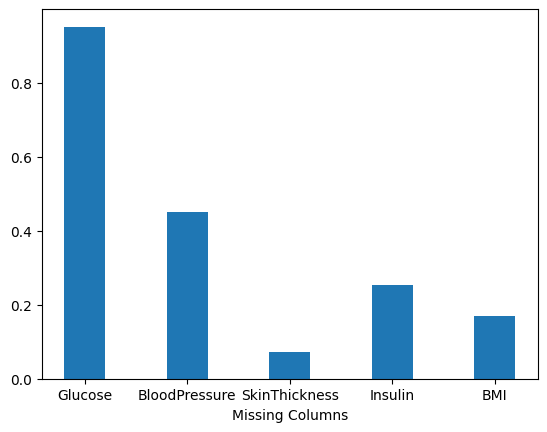

In [52]:
fig_0 = plt.figure()
plt.bar(list(p_value.keys()), list(p_value.values()), width = 0.4, label ='time')

plt.xlabel("Missing Columns")
plt.show()

In [15]:
# Copy imputed data into original dataset
for feature in missing_columns:
    dataset[feature] = reg_imp_data["reg" + feature]

## Splitting Data

Deterministic Regression Imputation dataset is used from here for all classifiers

In [17]:
# Split data
train = dataset.sample(frac = 0.8, random_state = 1)
test = dataset.drop(train.index)

x_train = train.drop(columns = ['Outcome'])
y_train = train['Outcome']
x_test = test.drop(columns = ['Outcome'])
y_test = test['Outcome']

## Decision Tree Classifier

In [18]:
# Decision Tree
decision_tree = tree.DecisionTreeClassifier()
# Training
start = time.time()
decision_tree = decision_tree.fit(x_train, y_train)
dt_time = time.time() - start
print ("Training time:", dt_time)
# Predicting
dt_pred = decision_tree.predict(x_test)
# Model accuracy
dt_acc = metrics.accuracy_score(y_test, dt_pred)
print ("Decision Tree's Accuracy:", dt_acc)

Training time: 0.006997585296630859
Decision Tree's Accuracy: 0.8246753246753247


## Random Forest Classifier

In [19]:
# Random Forest (100 trees)
random_forest = RandomForestClassifier (n_estimators=100)
# Training
start = time.time()
random_forest.fit(x_train, y_train)
rf_time = time.time() - start
print ("Training time:", rf_time)
# Predicting
rf_pred = random_forest.predict(x_test)
# Model accuracy
rf_acc = metrics.accuracy_score(y_test, rf_pred)
print ("Random Forest's Accuracy:", rf_acc)

Training time: 0.14928722381591797
Random Forest's Accuracy: 0.8571428571428571


## Gaussian Naive Bayes Classifier

In [20]:
# Gaussian Naive Bayes
gaussian_nb = GaussianNB()
# Training
start = time.time()
gaussian_nb.fit(x_train, y_train)
gnb_time = time.time() - start
print ("Training time:", gnb_time)
# Predicting
gnb_pred = gaussian_nb.predict(x_test)
# Model accuracy
gnb_acc = metrics.accuracy_score(y_test, gnb_pred)
print ("Gaussian Naive Bayes's Accuracy:", gnb_acc)

Training time: 0.0020122528076171875
Gaussian Naive Bayes's Accuracy: 0.7662337662337663


## Multinomial Naive Bayes Classifier

In [21]:
# Multinomial Naive Bayes
multinomial_nb = MultinomialNB()
# Training
start = time.time()
multinomial_nb.fit(x_train, y_train)
mnb_time = time.time() - start
print ("Training time:", mnb_time)
# Predicting
mnb_pred = multinomial_nb.predict(x_test)
# Model accuracy
mnb_acc = metrics.accuracy_score(y_test, mnb_pred)
print ("Multinomial Naive Bayes's Accuracy:", mnb_acc)

Training time: 0.0019998550415039062
Multinomial Naive Bayes's Accuracy: 0.7532467532467533


## Logistic Linear Regression

In [22]:
# Logistic Linear Regression
linear_regression = LogisticRegression(max_iter = 200)
# Training
start = time.time()
linear_regression.fit(x_train, y_train)
lr_time = time.time() - start;
print ("Training time:", lr_time)
# Predicting
lg_pred = linear_regression.predict(x_test)
# Model accuracy
lr_acc = metrics.accuracy_score(y_test, lg_pred)
print ("Logistic Linear Regression's Accuracy:", lr_acc)

Training time: 0.025061368942260742
Logistic Linear Regression's Accuracy: 0.7597402597402597


## Classifiers Comparision

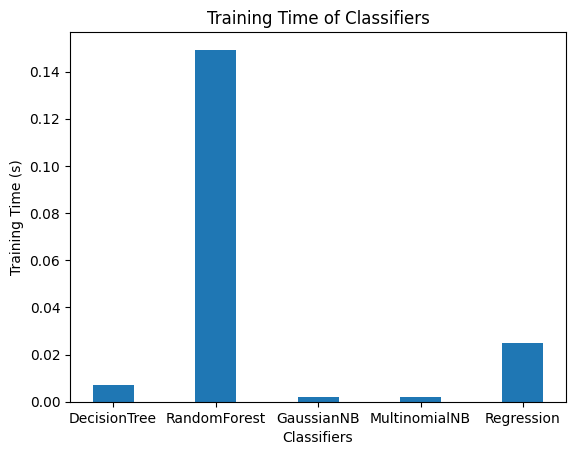

In [30]:
classifiers = ['DecisionTree', 'RandomForest', 'GaussianNB', 'MultinomialNB', 'Regression']
training_time = [dt_time, rf_time, gnb_time, mnb_time, lr_time]

fig_1 = plt.figure()
plt.bar(classifiers, training_time, width = 0.4, label ='time')

plt.xlabel("Classifiers")
plt.ylabel("Training Time (s)")
plt.title("Training Time of Classifiers")
plt.show()

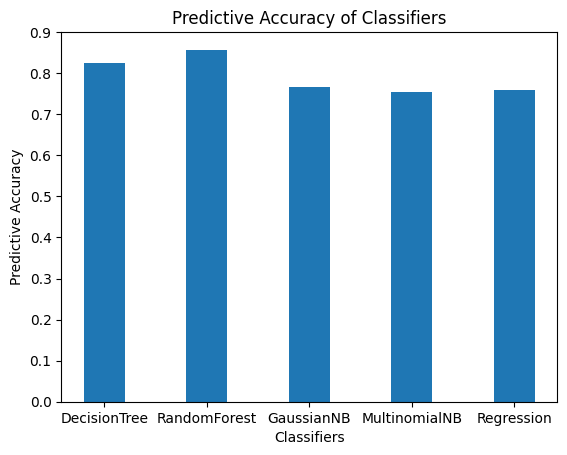

In [34]:
fig_2 = plt.figure()
accuracy = [dt_acc, rf_acc, gnb_acc, mnb_acc, lr_acc]
plt.bar(classifiers, accuracy, width = 0.4, label ='accuracy')

plt.xlabel("Classifiers")
plt.ylabel("Predictive Accuracy")
plt.title("Predictive Accuracy of Classifiers")
plt.show()

## Classifiers Conclusion

From two figures above, we can conclude:

| Classifiers | Training Time | Accuracy |
| :-: | :-: | :-: |
| Decision Tree | Low | High
| Random Forest | Highest | Highest
| Gaussian NB | Lowest | Medium
| Multinomial NB | Lowest | Medium
| Regression | Medium | Medium

**Decision Tree** is a good classifier for this particular problem. It has a low training time and a relatively high accurary.